In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import time

In [2]:
R = 0.02
SIGMA = 0.4
S_0 = 100
T = 0.9
K = np.arange(80, 121)

## Monte-Carlo simulation of the Greeks

In the context of the Black-Scholes model with constant interest rate $r$, constant volatility parameter $\sigma>0$ and Brownian motion $B$ under the risk-neutral measure:
$$dS_t = S_t(r\,dt+\sigma\,dB_t)$$

We are interested in the numerical approximation of the no arbitrage price of a binary option defined by the payoff $1_{\{S_T\le K\}}$ at the maturity date $T$, for some strike $K>0$, together with the corresponding optimal hedging strategy

$$C_0=e^{-rT} \mathbb{E}[1_{\{S_T\le K\}}]$$
et
$$\Delta_0=e^{-rT}\frac{\partial}{\partial S_0} \mathbb{E}[1_{\{S_T\le K\}}]$$

In terms of the cdf of the $\mathcal{N} (0,1)$ distribution, direct calculation leads to

$$C_0 = e^{-rT} N(-d_-(X_0,\sigma^2T)), \; \Delta_0 = \frac{-e^{-rT}}{S_0\sqrt{\sigma^2T}} N'(-d_-(X_0,\sigma^2T))$$

with

$$X_0 = \frac{S_0}{Ke^{-rT}}, \; d_-(x,v) = \frac{\ln(x)}{\sqrt v} - \frac{\sqrt v}{2}$$

### 1. We first focus on the Monte Carlo approximation of $C_0$

a. Build a program which returns $C_0$ and $\Delta_0$ for given values of $r,\sigma,S_0,T,K$ 

In [3]:
def C_0(r, sigma, S_0, T, K):
    """Returns C_0"""

    X_0 = S_0 / K * np.exp(r*T)
    dminus = np.log(X_0) / (sigma * np.sqrt(T)) - (sigma * np.sqrt(T)) / 2

    return np.exp(-r*T) * norm.cdf(-dminus)


def Delta_0(r, sigma, S_0, T, K):
    """Returns Delta_0"""

    X_0 = S_0 / K * np.exp(r*T)
    dminus = np.log(X_0) / (sigma * np.sqrt(T)) - (sigma * np.sqrt(T)) / 2

    return - np.exp(-r*T) / (S_0 * sigma * np.sqrt(T)) * norm.pdf(-dminus)

Let's visualize $C_0$ and $\Delta_0$

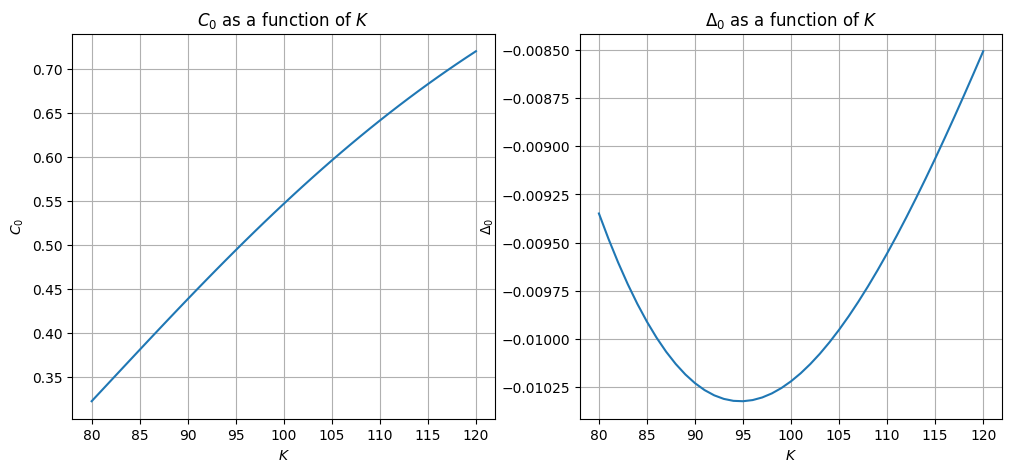

In [4]:
C = np.array([C_0(r=R, sigma=SIGMA, S_0=S_0, T=T, K=k) for k in K])
D = np.array([Delta_0(r=R, sigma=SIGMA, S_0=S_0, T=T, K=k) for k in K])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,5))

ax1.plot(K, C)
ax1.set_xlabel("$K$")
ax1.set_ylabel("$C_0$")
ax1.set_title("$C_0$ as a function of $K$")
ax1.grid()

ax2.plot(K, D)
ax2.set_xlabel("$K$")
ax2.set_ylabel("$\Delta_0$")
ax2.set_title("$\Delta_0$ as a function of $K$")
ax2.grid()

plt.show()

b. Build a program which returns a Monte Carlo approximation $C_0^M$ of $C_0$ based on $M$ copied of $B_T$.

**Answer** We have the following non-differential expression of $S_t$:
$$S_t=S_0 e^{(r-\sigma^2/2)t+\sigma B_t}, \; t\ge0$$
Therefore
$$C_0 = e^{-rT} \mathbb{E}\big[ 1\{ S_0 e^{(r-\sigma^2/2)T+\sigma B_T} \le K\}\big]
$$
This expected value can be approximated with a Monte Carlo method

In [5]:
def CM_0(r, sigma, S_0, T, K, M):
    """Returns C_0^M a Monte Carlo approximation of C_0 based on M copies of B_T"""

    # We first simulate B_T, which follows a normal distribution, M times
    B_T = norm.rvs(size=int(M), loc=0, scale=np.sqrt(T))
    # Then we compute S_T from B_T
    S_T = S_0 * np.exp((r-sigma**2/2)*T + sigma*B_T)

    return np.exp(-r*T) * np.mean(S_T <= K)

c. Discuss the numerical results for various strikes $K$ sample sizes $M$.

Let's first plot a first Monte-Carlo simulation, for several values of $M$ and $K$.

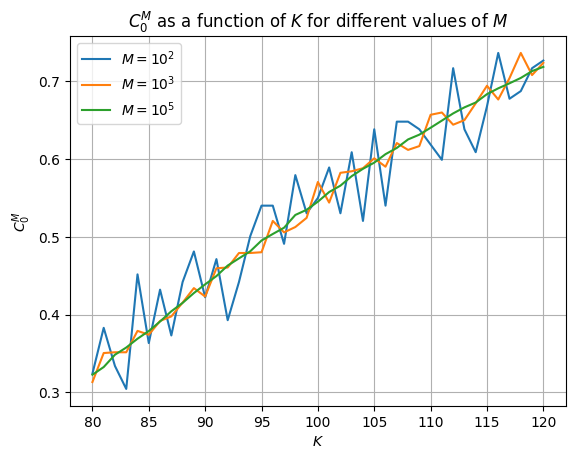

In [6]:
plt.plot(K, [CM_0(R, SIGMA, S_0, T, k, M=100) for k in K], label="$M=10^2$")
plt.plot(K, [CM_0(R, SIGMA, S_0, T, k, M=1000) for k in K], label="$M=10^3$")
plt.plot(K, [CM_0(R, SIGMA, S_0, T, k, M=100000) for k in K], label="$M=10^5$")
plt.xlabel("$K$")
plt.ylabel("$C^M_0$")
plt.title("$C^M_0$ as a function of $K$ for different values of $M$")
plt.legend()
plt.grid()
plt.show()

It seems that the upper the sample size $M$, the more precise and accurate the Monte-Carlo simulation is.

Let's repeat the simulation for different values of $M$, and look at the average relative error and the variance between simulations.

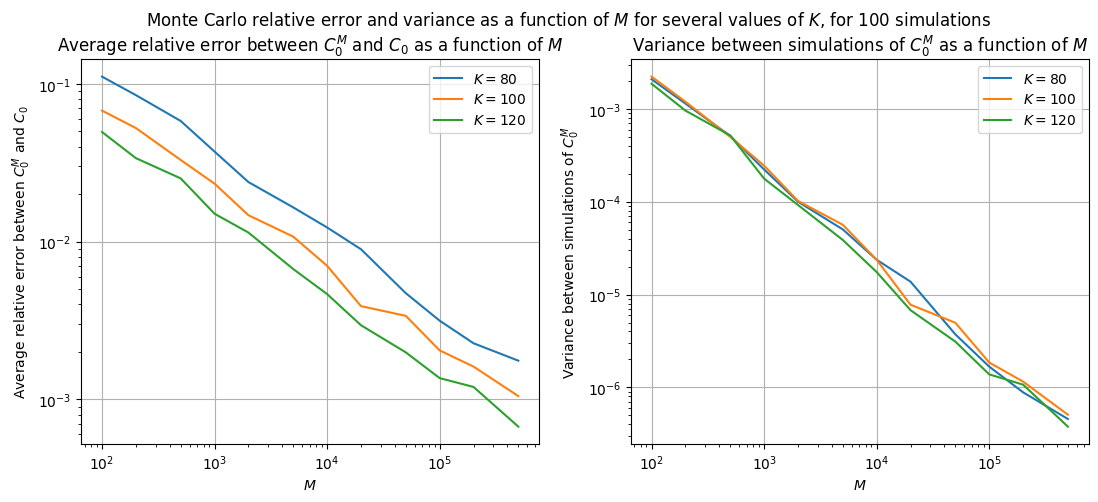

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(13, 5))

M = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000]
N_SIMUS = 100

for k in [80, 100, 120]:

    C0 = C_0(R, SIGMA, S_0, T, k)

    # For each value of M and K, we repeat several times the simulation
    MC_simulations = np.zeros((N_SIMUS, len(M)))
    for i in range(N_SIMUS):
        MC_simulations[i] = np.array([CM_0(R, SIGMA, S_0, T, k, m) for m in M])

    average_relative_error = np.mean(abs(MC_simulations - C0)/C0, axis=0)
    simulations_variance = np.var(MC_simulations, axis=0)

    ax1.plot(M, average_relative_error, label=f"$K={k}$")
    ax2.plot(M, simulations_variance, label=f"$K={k}$")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$M$")
ax1.set_ylabel("Average relative error between $C^M_0$ and $C_0$")
ax1.set_title("Average relative error between $C^M_0$ and $C_0$ as a function of $M$")
ax1.grid()
ax1.legend()

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("$M$")
ax2.set_ylabel("Variance between simulations of $C^M_0$")
ax2.set_title("Variance between simulations of $C^M_0$ as a function of $M$")
ax2.grid()
ax2.legend()

fig.suptitle(f"Monte Carlo relative error and variance as a function of $M$ for several values of $K$, for ${N_SIMUS}$ simulations")
plt.show()

As conjectured, the Monte-Carlo simulation does converges to the exact value of $C_0$ as $M$ increases, for every $K$.

In particular, the rate at which it converges is about $\frac{1}{\sqrt M}$, as showed by the slope of $1/2$ in logarithmic scale. This is indeed the theoretical convergence rate for a Monte Carlo simulation.

Moreover, the variance of the Monte Carlo approximation decreases as a function of $M$, with a rate of $\frac{1}{M}$

### 2. We denote $C^M_0(S_0)$ to emphasize the dependence of this function on $S_0$.

a. Build a program which returns the centered finite-differences approximation of $\Delta_0$ and the corresponding 5% confidence interval:
$$\Delta^{M,\varepsilon}_0 = \frac{C_0^M(S_0+\varepsilon) - C_0^M(S_0-\varepsilon)}{2\varepsilon}$$

In [8]:
def Delta_MC(r, sigma, S_0, T, K, M, eps):

    return (CM_0(r, sigma, S_0+eps, T, K, M) - CM_0(r, sigma, S_0-eps, T, K, M)) / (2*eps)

b. Using the parameters values of Question 1c, discuss numerically the
choice of the parameters $\varepsilon$ and $M$.

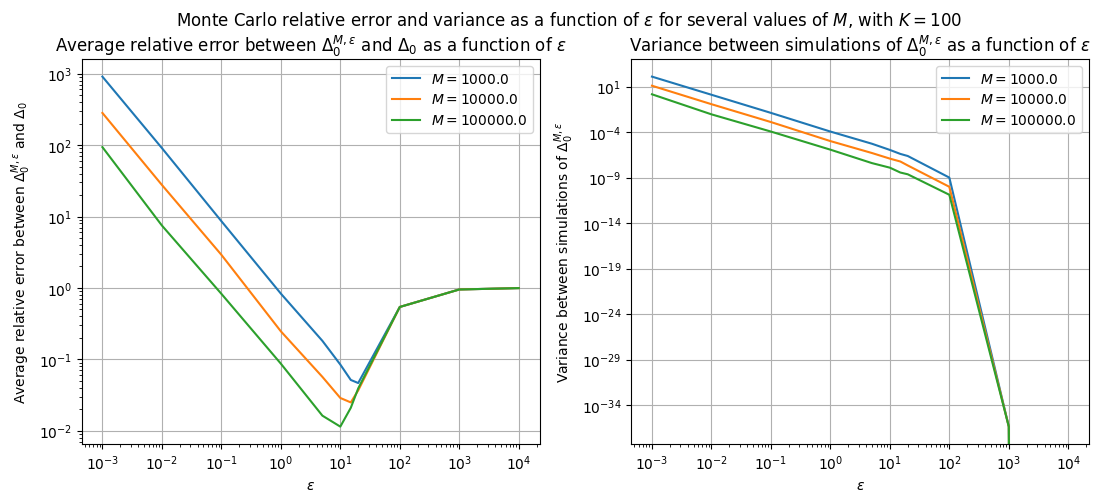

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(13, 5))

EPS = [1e-3, 1e-2, 1e-1, 1, 5, 1e1, 15, 20, 1e2, 1e3, 1e4]
N_SIMUS = 100
k = 100

for M in [1e3, 1e4, 1e5]:

    D = Delta_0(R, SIGMA, S_0, T, k)

    # For each value of eps and M, we repeat several times the simulation
    MC_simulations = np.zeros((N_SIMUS, len(EPS)))
    for i in range(N_SIMUS):
        MC_simulations[i] = np.array([Delta_MC(R, SIGMA, S_0, T, k, M, eps) for eps in EPS])

    average_relative_error = np.mean(abs((MC_simulations - D)/D), axis=0)
    simulations_variance = np.var(MC_simulations, axis=0)

    ax1.plot(EPS, average_relative_error, label=f"$M={M}$")
    ax2.plot(EPS, simulations_variance, label=f"$M={M}$")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$\epsilon$")
ax1.set_ylabel("Average relative error between $\Delta^{M,\epsilon}_0$ and $\Delta_0$")
ax1.set_title("Average relative error between $\Delta^{M,\epsilon}_0$ and $\Delta_0$ as a function of $\epsilon$")
ax1.grid()
ax1.legend()

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Variance between simulations of $\Delta^{M,\epsilon}_0$")
ax2.set_title("Variance between simulations of $\Delta^{M,\epsilon}_0$ as a function of $\epsilon$")
ax2.grid()
ax2.legend()

fig.suptitle(f"Monte Carlo relative error and variance as a function of $\epsilon$ for several values of $M$, with $K=100$")
plt.show()

In the same way as for the previous question, as the sample size $M$ inreases, the approximation accuracy increases and its variance decreases.

As for the parameter $\varepsilon$, the variance between simulations is decreasing in $\varepsilon$, while the relative error has a more interesting behavior:
As $\varepsilon$ increases, the relative error decreases with a rate of $1/\varepsilon$, up to a minimum, and then increases back up to $1$.
This minimum value and position change with $M$. For $M=10^5$, the best choice for $\varepsilon$ is around $\varepsilon=10$.

In conclusion, the higher the sample size $M$ is, the better the approximation is, but the more costly it is. For $\varepsilon$, there is a finite value where the approximation is optimal, which depends on $M$.

### 3.
By writing the price $C_0$ as an integral with respect to the distribution of $S_T$, we obtain the following representation:
$$\Delta_0 = e^{-rT}\mathbb E \big[ 1_{\{S_T\le K\}} \frac{B_T}{S_0\sigma T} \big]$$

a. Build a program which returns a Monte Carlo approximation $\hat\Delta_0^M$ of $\Delta_0$ based on the last representation.

In [10]:
def DeltaHat(r, sigma, S_0, T, K, M):
    """Returns DeltaHat_0^M a Monte Carlo approximation of Delta_0 based on M copies of B_T"""

    # We first simulate B_T, which follows a normal distribution, M times
    B_T = norm.rvs(size=int(M), loc=0, scale=np.sqrt(T))
    # Then we compute S_T from B_T
    S_T = S_0 * np.exp((r-sigma**2/2)*T + sigma*B_T)

    X = (S_T <= K) * B_T / S_0 / sigma / T

    return np.exp(-r*T) * np.mean(X)

b. Using the parameters values of Question 1c, compare the performances of the approximation $\Delta_0^M$ and $\hat\Delta_0^M$

**Answer** 

There are several ways of comparing the Monte Carlo approximations. Let's first take $M$ constant equals to $10^5$ and compare the approximations for all values of $K$.

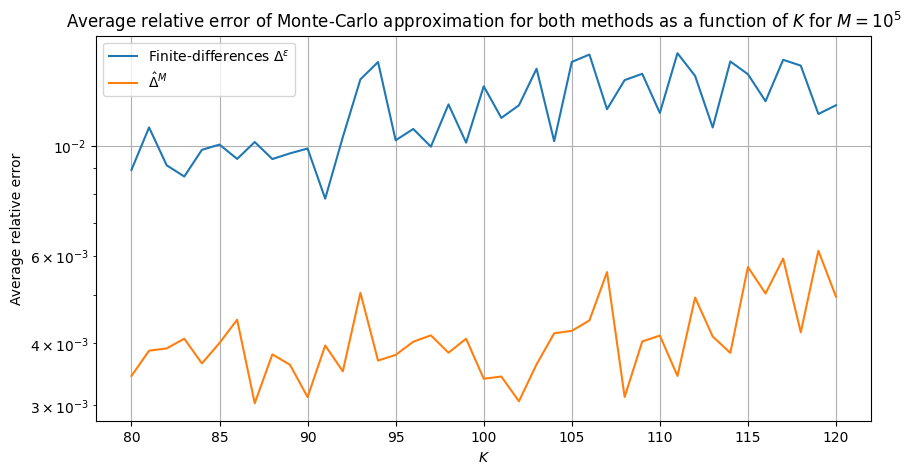

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))

N_SIMUS = 25
M = 1e5
OPT_EPS = 10 # As shown in the question 2b, the optimal value for the approximation of Delta_0^M,epsilon, is around epsilon=10 for M=1e5

D = np.array([Delta_0(R, SIGMA, S_0, T, k) for k in K])

# For each value of K, we repeat several times the simulation
MC_simulations_epsilon = np.zeros((N_SIMUS, len(K)))
MC_simulations_hat = np.zeros((N_SIMUS, len(K)))

for i in range(N_SIMUS):
    MC_simulations_epsilon[i] = np.array([Delta_MC(R, SIGMA, S_0, T, k, M, OPT_EPS) for k in K])
    MC_simulations_hat[i] = np.array([DeltaHat(R, SIGMA, S_0, T, k, M) for k in K])

average_relative_error_epsilon = np.mean(abs((MC_simulations_epsilon - D)/D), axis=0)
average_relative_error_hat = np.mean(abs((MC_simulations_hat - D)/D), axis=0)

ax1.plot(K, average_relative_error_epsilon, label=f"Finite-differences $\Delta^\epsilon$")
ax1.plot(K, average_relative_error_hat, label=f"$\hat\Delta^M$")

ax1.set_yscale("log")
ax1.set_xlabel("$K$")
ax1.set_ylabel("Average relative error")
ax1.set_title("Average relative error of Monte-Carlo approximation for both methods as a function of $K$ for $M=10^5$")
ax1.grid()
ax1.legend()

plt.show()

For $M=10^5$, the second Monte-Carlo method gives a better approximation of $\Delta_0$ than the finite-differences method, regardless of the value of $K$.

However, we cannot conclude that the second method is better, as it could be more costly to run one simulation for the second method than for the first method. Therefore, we have to compare the performances of the approximations with constant computation cost.

Let's therefore fix $K=100$, and plot the average relative error as a function of the computation time, by varying the value of $M$ between $10^2$ and $10^5$.

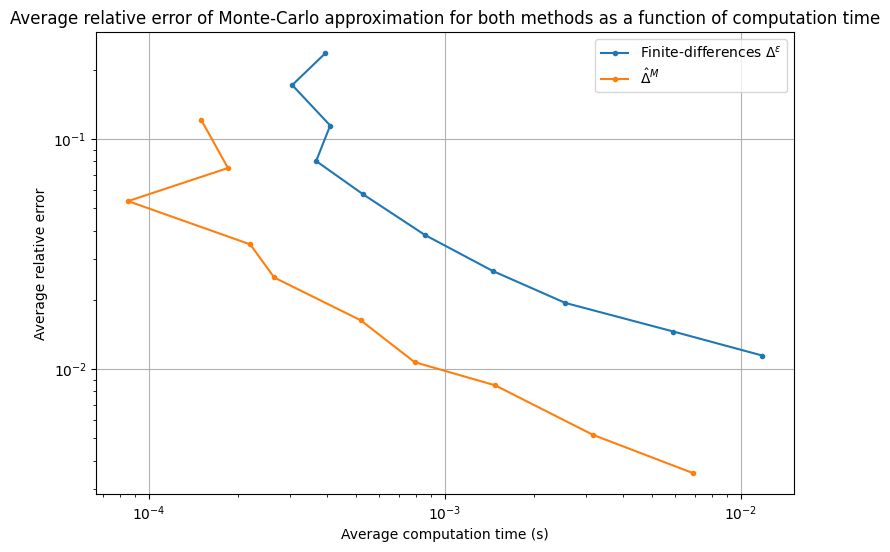

In [12]:
N_SIMUS = 200

k = 100
M = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
EPS = 10 # For the sake of simplicty, we keep epsilon=10 for the finite-differences approximation

D = Delta_0(R, SIGMA, S_0, T, k)

MC_simulations_epsilon = np.zeros((N_SIMUS, len(M)))
MC_simulations_hat = np.zeros((N_SIMUS, len(M)))

time_taken_epsilon = np.zeros((N_SIMUS, len(M)))
time_taken_hat = np.zeros((N_SIMUS, len(M)))


for i in range(N_SIMUS):
    for j, m in enumerate(M):

        time_start = time.time()
        MC_simulations_epsilon[i, j] = Delta_MC(R, SIGMA, S_0, T, k, m, EPS)
        time_end = time.time()
        time_taken_epsilon[i, j] = time_end - time_start

        time_start = time.time()
        MC_simulations_hat[i, j] = DeltaHat(R, SIGMA, S_0, T, k, m)
        time_end = time.time()
        time_taken_hat[i, j] = time_end - time_start

average_relative_error_epsilon = np.mean(abs((MC_simulations_epsilon - D)/D), axis=0)
average_relative_error_hat = np.mean(abs((MC_simulations_hat - D)/D), axis=0)

average_comp_time_epsilon = np.mean(time_taken_epsilon, axis=0)
average_comp_time_hat = np.mean(time_taken_hat, axis=0)

fig, ax1 = plt.subplots(figsize=(9, 6))

ax1.plot(average_comp_time_epsilon, average_relative_error_epsilon, marker='.', label=f"Finite-differences $\Delta^\epsilon$")
ax1.plot(average_comp_time_hat, average_relative_error_hat, marker='.', label=f"$\hat\Delta^M$")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Average computation time (s)")
ax1.set_ylabel("Average relative error")
ax1.set_title("Average relative error of Monte-Carlo approximation for both methods as a function of computation time")
ax1.grid()
ax1.legend()

plt.show()

For a given $M$, the finite-differences approximation method is both less accurate, and more costly in term of computation time. So for a given computation time, the second method gives a better approximation.

Therefore, we can conclude that the approximation $\hat\Delta_0^M$ is better than the approximation $\Delta_0^{M,\varepsilon}$.